# Downloading seismic data

Sébastien MEYER, Adrienne TUYNMAN

In this notebook, we will use routines from our source code to download, transform and prepare seismic data for both visualization and change detection. Our functions rely on the `obspy` package.

Data downloading is done through the `Client` object.

In [1]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime


from src.data_preparation import prepare_ppsd, prepare_rms
from src.utils.plotting import plot_ppsd, plot_rms

## Find a station where data is available

The first step for preparing seismic data is to check for the availability of data on the globe. For that, you can use different methods from the `obspy` package. More specifically, the method `get_stations` checks for available stations, based on criteria such as: data provider, network, station, location, channel, start date, end date, min latitude, max latitude, min longitude and max longitude.

Here, we are interested in finding a station near Strasbourg, France which embeds a BHZ channel (20 samples per second). 

Inventory created at 2023-03-27T15:08:37.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2020-03-...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (1):
			FR
		Stations (1):
			FR.STR (Strasbourg)
		Channels (1):
			FR.STR.00.BHZ


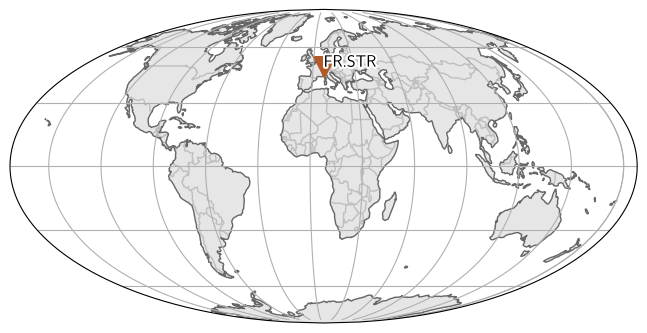

In [2]:
provider_name = "RESIF"

client = Client(provider_name)

network = "FR"
station = "STR"
location = "00"
channel = "BHZ"

starttime = UTCDateTime(2020, 3, 17)
endtime = UTCDateTime(2020, 3, 18)

inventory = client.get_stations(
    starttime=starttime, 
    network=network, station=station, location=location, channel=channel, 
    level="channel"
)

print(inventory)

_ = inventory.plot()

Great, we find that such a station exists! Now, we want to test if data is available for our dates of interest. Indeed, a station being available in the inventory does not necessarily mean that the data is *publicly* available. Let us send a query for 15.03.2020. This can be done through the `get_waveforms` method.

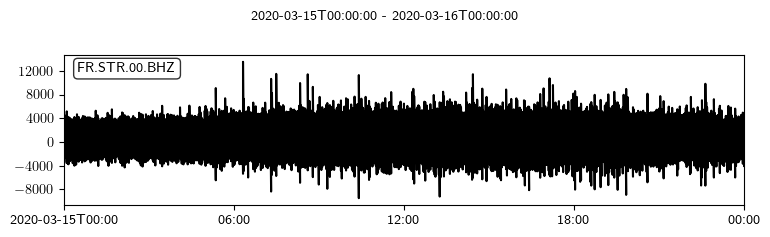

In [3]:
provider_name = "RESIF"

client = Client(provider_name)

network = "FR"
station = "STR"
location = "00"
channel = "BHZ"

starttime = UTCDateTime(2020, 3, 15)
endtime = UTCDateTime(2020, 3, 16)

st = client.get_waveforms(network, station, location, channel, starttime, endtime)

_ = st.plot()  

Data is available for our selected dates and station! Therefore, we can start querying more data and prepare it for further analysis.

## Compute power spectral density values over a date range

In order to download a lot of data from this station, you can use the routine `prepare_ppsd` from our source code. This function first downloads the raw waveforms using the `get_waveforms_bulk` method, and then process it to compute the power spectral densities. Note that we use custom parameters for computing the PSD, as mentioned [here](https://github.com/ThomasLecocq/SeismoRMS/blob/master/SeismoSocialDistancing.ipynb).

In [4]:
data_dir = "data"

provider_name = "RESIF"
network = "FR"
station = "STR"
location = "00"
channel = "BHZ"

start_date = "2020-01-01"
end_date = "2022-01-01"

ppsd_dfs = prepare_ppsd(
    data_dir=data_dir,
    provider_name=provider_name,
    network=network,
    station=station,
    location=location,
    channel=channel,
    start_date=start_date,
    end_date=end_date
)

Converting PPSD to dataframe (FR.STR.00.BHZ): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.36s/it]


Moreover, we provide plotting functions for visualization. Let us plot the power spectral density values for a given range of frequencies and dates.

**Remark.** As the number of points in the complete PPSD dataframes can be huge, we advise you to restrict the PPSD plotting to a few days only.

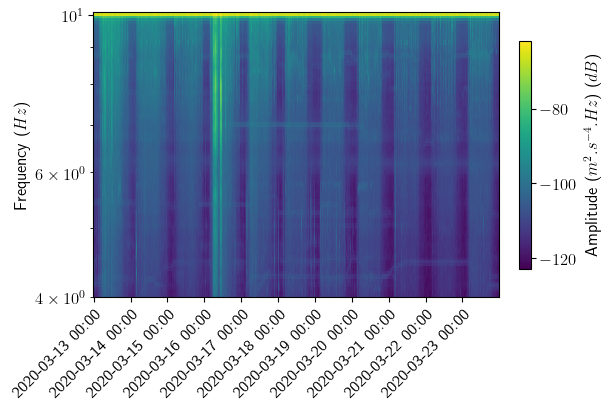

In [5]:
ppsd_df = ppsd_dfs["FR.STR.00.BHZ"]

start_date_plot = "2020-03-13"
end_date_plot = "2020-03-23"

min_freq_plot = 4.0
max_freq_plot = 14.0

plot_ppsd(
    ppsd_df,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    min_freq_plot=min_freq_plot,
    max_freq_plot=max_freq_plot,
    savefig=False
)

It is already possible to observe that the PSD contains an anomaly on March 16, 2020. In fact, these extreme values correspond to the first day of the national lockdown in France! This phenomenon can be explained by the fact that a lot of people were buying food, moving away from the city, etc. before the lockdown was enforced.

## Compute the displacement over a date range

From the power spectral density values, one can compute the displacement (in *nm*) of the sensor. This creates an univariate time series which can be further analyzed. Our routine function `prepare_rms` loads again the PSD values, computes and saves the displacement time series in a csv file.

In [6]:
freqs_pairs = [(0.1, 1.0), (1.0, 20.0), (4.0, 14.0), (4.0, 20.0)]
output = "displacement"

save = True

rms_dfs = prepare_rms(
    ppsd_dfs=ppsd_dfs,
    data_dir=data_dir,
    start_date=start_date,
    end_date=end_date,
    freqs_pairs=freqs_pairs,
    output=output,
    save=save
)

Saving RMS displacement data (FR.STR.00.BHZ): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Let us plot the power spectral density values for a given range of frequencies and dates.

**Remark**. The naming convention for frequency band is "[{start_freq:.2f}, {end_freq:.2f}] Hz". For example, the first band can be retrieved by calling `rms_df["[0.10, 1.00] Hz"]`.

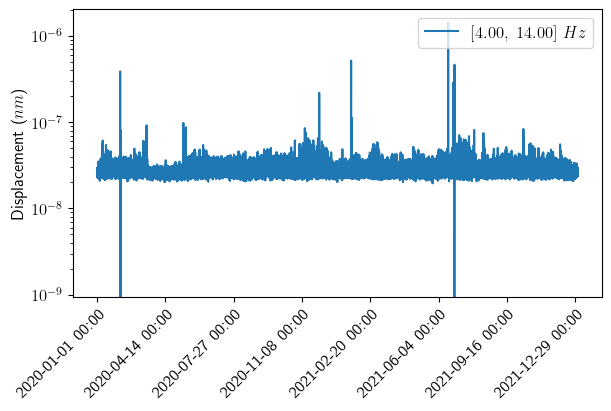

In [8]:
rms_df = rms_dfs["FR.STR.00.BHZ"]

start_date_plot = "2020-01-01"
end_date_plot = "2022-01-01"

bands_plot = ["[4.00, 14.00] Hz"]

plot_rms(
    rms_df=rms_df,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    bands_plot=bands_plot,
    savefig=False
)

As we can see, we observe very different behaviors wrt the chosen frequency band. For instance, the band between 0.10 and 1.00 $Hz$ is not very informative. However, we know that urban noise (foot steps, etc.) are more generally found aboe 1 $Hz$. From the band between 4.00 and 14.00 $Hz$, one can notice the very "flat" aspect of the displacement between 16.03.2020 (lockdown start date) and 11.05.2020 (lockdown end date). 

Also, notice how the displacement is very small compared to other bands. For urban noise, the displacement lies between 1 and 100 $nm$.

---------------